 # 12.1 - Model selection - Random forests - temporary crops
 
The goal of ths notebook is to build a model for the prediction of invertebrate pest consumption by birds in **temporary crops**.

The model uses as predictor features:
- bird counts at point locations
- bird counts for guild classes
- descriptors of the agricultural landscape of buffer areas of the bird point locations 

#### Inputs

- data table prepared by step 11: corr_data_filter.csv

In [1]:
# import modules
import pandas as pd
import numpy as np
from scipy.stats import entropy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
%matplotlib inline

In [2]:
# read point level data, simple format
corr_data_filter = pd.read_csv('../process_data/corr_data.csv')
corr_data_filter.shape

(10912, 52)

The dataset contains 5064 rows, corresponding to sampling point buffers.

In [41]:
# function to calculate model error
def get_error(y_test, prediction):
    mse = mean_squared_error(y_test, prediction)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, prediction)
    mae = mean_absolute_error(y_test, prediction)
    perc_mae = mae/np.mean(y_test)*100
    perc_rmse = rmse/np.mean(y_test)*100
    return  {"test mse":mse, "rmse": rmse, "perc_rmse": perc_rmse, "mae": mae, "perc_mae": perc_mae, "r2": r2 }

### 1. Prepare the data table

First, we define the list of parameters to be included as predictor features:

In [4]:
# Set list of features

feature_vars = ['log_count_ind_annual', 'log_count_ind_perm','log_count_sps_annual','log_obs_count_total',
       'log_count_sps_perm', 'shannon', 'richness','log_Tree_high', 'Tree_low', 'Tree_medium',
       'log_Invertivore_Generalist_Generalist', 'log_Invertivore_Insessorial', 
       'log_Invertivore_sally_ground', 'log_Invertivore_sally_surface', 
       'log_Invertivore_sally_air', 'log_Invertivore_Aerial', 'log_Invertivore_bark', 
       'log_Invertivore_Generalist', 'log_Invertivore_Insessorial_Generalist',
       'log_Invertivore_ground', 'log_Omnivore_Generalist',
       'log_Invertivore_glean_arboreal', 'log_Omnivore_Insessorial',
       'log_Invertivore_aerial', 'log_Omnivore_Terrestrial', 
       'entr_f_area','log_total_crop_area', 'total_feed_area',
       'log_total_wood_area',
       'log_total_temp_area', 'log_total_perm_area']

df_to_model = corr_data_filter

In [5]:
# define the predictor features of the model
X = df_to_model[feature_vars]

In [6]:
X.describe().T

,count,mean,std,min,25%,50%,75%,max
log_count_ind_annual,10912.0,2.047546,1.142954,6.931472e-01,1.098612,1.791759,2.639057,8.853808
log_count_ind_perm,10912.0,2.462778,1.051334,6.931472e-01,1.791759,2.397895,2.995732,8.853808
log_count_sps_annual,10912.0,1.189219,0.424561,6.931472e-01,0.693147,1.098612,1.386294,2.639057
log_obs_count_total,10912.0,2.462778,1.051334,6.931472e-01,1.791759,2.397895,2.995732,8.853808
log_count_sps_perm,10912.0,1.611940,0.547748,6.931472e-01,1.098612,1.609438,1.945910,3.367296
shannon,10912.0,1.121385,0.678743,-2.220446e-16,0.636514,1.120024,1.634759,2.863376
richness,10912.0,4.808376,3.240382,1.000000e+00,2.000000,4.000000,6.000000,28.000000
log_Tree_high,10912.0,0.123438,0.163321,0.000000e+00,0.000000,0.000000,0.223144,0.693147
Tree_low,10912.0,0.413219,0.351064,0.000000e+00,0.074074,0.333333,0.718306,1.000000
Tree_medium,10912.0,0.439215,0.321576,0.000000e+00,0.166667,0.400000,0.666667,1.000000


We also define the target variable:

In [7]:
# define the label feature of the model
y = df_to_model['log_point_cons_temp_ha']

In [8]:
y.describe()

count    10912.000000
mean         5.991330
std          1.884711
min          0.730405
25%          4.907885
50%          6.076744
75%          7.185624
max         13.656822
Name: log_point_cons_temp_ha, dtype: float64

### 2. Create the model with all features

The next step creates the train and test subsets. Below, the number of rows of each subset.

In [9]:
# create the train and test subsets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split( X.values, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (8729, 31) (8729,)
Test set: (2183, 31) (2183,)


Now, we can define our Random Forest model. The hyperparameters were determined in the previous step by GridSearchCV.

In [10]:
# Create the RF object. Hyperparameters obtained from Data transformation
from sklearn.ensemble import RandomForestRegressor
feature_names = X.columns
model_rf = RandomForestRegressor(max_depth=10, max_features='sqrt', n_estimators=1000,
                      random_state=18)
model_rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, max_features='sqrt', n_estimators=1000,
                      random_state=18)

The output of the next step prints out the following performance metrics of the model, when applied to the test subset: mean square error, root mean square error, mean absolute error and the coeficcient of determination, r2. The later can be interpreted as the fraction of tghe variance that is represented by the model.

In [11]:
# make a prediction and get evaluation metrics
prediction = model_rf.predict(X_test)
print(get_error(y_test, prediction))

{'test mse': 0.7279448298820065, 'rmse': 0.8531968295077089, 'mae': 0.6314150552942198, 'r2': 0.795214634428665}


The next two cells prepare a plot of the feature importances. It starts by determining the standard error to add to each mean value.

In [12]:
# determine feature importance
import time

start_time = time.time()
importances = model_rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in model_rf.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 0.110 seconds


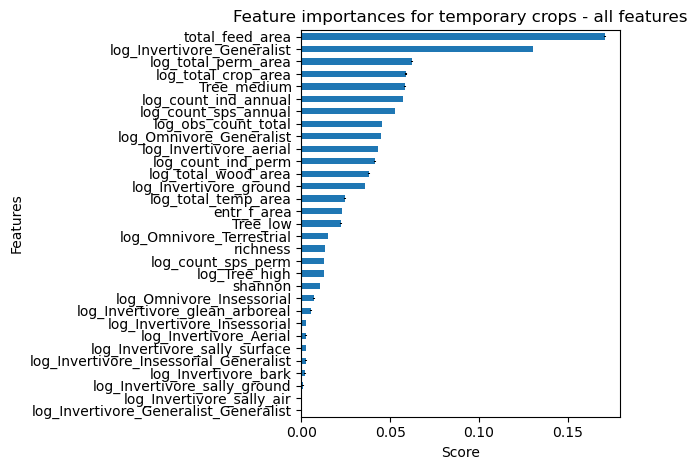

In [13]:
# plot feature importance
features_importances = pd.Series(importances, index=feature_names)
v = features_importances.sort_values(ascending=True)

fig, ax = plt.subplots()
v.plot.barh(yerr=std, ax=ax)
ax.set_title("Feature importances for temporary crops - all features")
ax.set_xlabel("Score")
ax.set_ylabel("Features")
plt.savefig('../output/figures/feature_importance_temp.png', dpi=300, bbox_inches='tight')
fig.tight_layout()

In [14]:
features_importances

log_count_ind_annual                      0.057343
log_count_ind_perm                        0.041477
log_count_sps_annual                      0.052877
log_obs_count_total                       0.045358
log_count_sps_perm                        0.012820
shannon                                   0.010637
richness                                  0.013500
log_Tree_high                             0.012585
Tree_low                                  0.022085
Tree_medium                               0.058653
log_Invertivore_Generalist_Generalist     0.000013
log_Invertivore_Insessorial               0.002695
log_Invertivore_sally_ground              0.000766
log_Invertivore_sally_surface             0.002487
log_Invertivore_sally_air                 0.000566
log_Invertivore_Aerial                    0.002549
log_Invertivore_bark                      0.002204
log_Invertivore_Generalist                0.130554
log_Invertivore_Insessorial_Generalist    0.002450
log_Invertivore_ground         

We will also prepare a biplot between the calculated and predicted pest consumption values, for the test subset.

<Axes: xlabel='log_point_cons_temp_ha'>

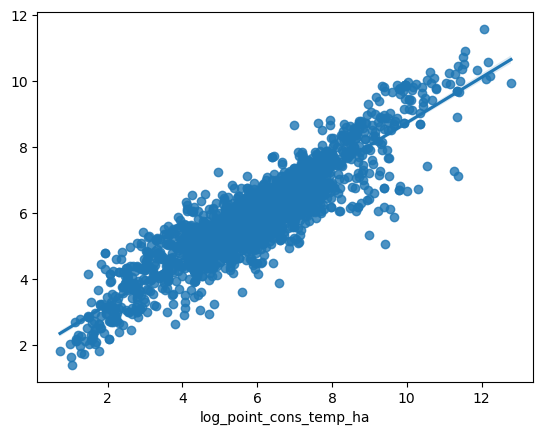

In [15]:
sns.regplot(x=y_test, y=prediction)

### 3. Make the feature selection

As we observed in the feature contribution graph, not all contribute to the model. We will make a feature selection, to simplify our model.

In [16]:
from sklearn.feature_selection import SelectFromModel

# Create and train the RandomForestRegressor model
rf_model = RandomForestRegressor(max_depth=10, max_features='sqrt', n_estimators=1000,
                      random_state=18)
rf_model.fit(X_train, y_train)

# Create a SelectFromModel object with the pre-trained RandomForestRegressor
sfm = SelectFromModel(rf_model, threshold='median')

# Fit the SelectFromModel to select important features
sfm.fit(X_train, y_train)

# Transform the feature set to keep only the selected features
X_train_selected = sfm.transform(X_train)
X_test_selected = sfm.transform(X_test)

# Retrieve the support mask (a boolean array indicating selected features)
support = sfm.get_support()

# Print selected features
print("Selected features:")
for i, selected in enumerate(support):
    if selected:
        print(f"Feature {i}: importance {rf_model.feature_importances_[i]}")
        


selected_features = np.array(feature_names)[support]

Selected features:
Feature 0: importance 0.057343490860206986
Feature 1: importance 0.04147732095538649
Feature 2: importance 0.05287725175880561
Feature 3: importance 0.04535783747302255
Feature 8: importance 0.02208487600357391
Feature 9: importance 0.05865290054696874
Feature 17: importance 0.13055407538231298
Feature 19: importance 0.035657221713025926
Feature 20: importance 0.04467161128557812
Feature 23: importance 0.04328999313922527
Feature 25: importance 0.022811907517443546
Feature 26: importance 0.058831627717649056
Feature 27: importance 0.17098709463835152
Feature 28: importance 0.038102955066268505
Feature 29: importance 0.02436992112126511
Feature 30: importance 0.06238612665682915


In [21]:
selected_features

array(['log_count_ind_annual', 'log_count_ind_perm',
       'log_count_sps_annual', 'log_obs_count_total', 'Tree_low',
       'Tree_medium', 'log_Invertivore_Generalist',
       'log_Invertivore_ground', 'log_Omnivore_Generalist',
       'log_Invertivore_aerial', 'entr_f_area', 'log_total_crop_area',
       'total_feed_area', 'log_total_wood_area', 'log_total_temp_area',
       'log_total_perm_area'], dtype=object)

There are 16 features that pass the importance criteria to be used in the model. The list above prints their names.

### 4. Create the final model

Let's create the model with the final set of features selected.

In [22]:
feature_vars = list(selected_features)

In [23]:
X = df_to_model[feature_vars]

In [24]:
X.columns

Index(['log_count_ind_annual', 'log_count_ind_perm', 'log_count_sps_annual',
       'log_obs_count_total', 'Tree_low', 'Tree_medium',
       'log_Invertivore_Generalist', 'log_Invertivore_ground',
       'log_Omnivore_Generalist', 'log_Invertivore_aerial', 'entr_f_area',
       'log_total_crop_area', 'total_feed_area', 'log_total_wood_area',
       'log_total_temp_area', 'log_total_perm_area'],
      dtype='object')

In [25]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split( X.values, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (8729, 16) (8729,)
Test set: (2183, 16) (2183,)


In [27]:
y_test.describe()

count    2183.000000
mean        5.975013
std         1.885816
min         0.730405
25%         4.844901
50%         6.024197
75%         7.131577
max        12.783426
Name: log_point_cons_temp_ha, dtype: float64

In [28]:
# Create the RF object
from sklearn.ensemble import RandomForestRegressor
feature_names = X.columns
model_rf = RandomForestRegressor(max_depth=10, max_features='sqrt', n_estimators=1000,
                      random_state=18)
model_rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, max_features='sqrt', n_estimators=1000,
                      random_state=18)

### 5. Make a cross validation

The cross validation allows to evaluate for possible over-fitting of the model. The procedure is to divide the training in a certain number of subsets, and use at at time to perform a test of the model.

In [29]:
%%time
# perform cross validation, using r2 as metrics
from sklearn.model_selection import cross_val_score

num_folds = 5
scores = cross_val_score(model_rf, X_train, y_train, cv=num_folds, scoring='r2', n_jobs=6)

CPU times: user 19.3 ms, sys: 70.6 ms, total: 89.9 ms
Wall time: 7.86 s


In [30]:
# CV scores
scores

array([0.80215726, 0.82581353, 0.80742226, 0.82243555, 0.81260906])

In [31]:
# CV scores mean and standard deviation
print(np.mean(scores))
print(np.std(scores))

0.8140875332449624
0.008900916014331942


The scores of the five CV runs are similar, and give good expalation rate to the variance, indicating that there is no obvious overfitting in the model.

Next, we print the performance metrics of the model.

In [42]:
prediction = model_rf.predict(X_test)
print(get_error(y_test, prediction))

{'test mse': 0.6578521537564399, 'rmse': 0.8110808552520765, 'perc_rmse': 13.574545684593916, 'mae': 0.5961359158626331, 'perc_mae': 9.977148605720133, 'r2': 0.81493309895375}


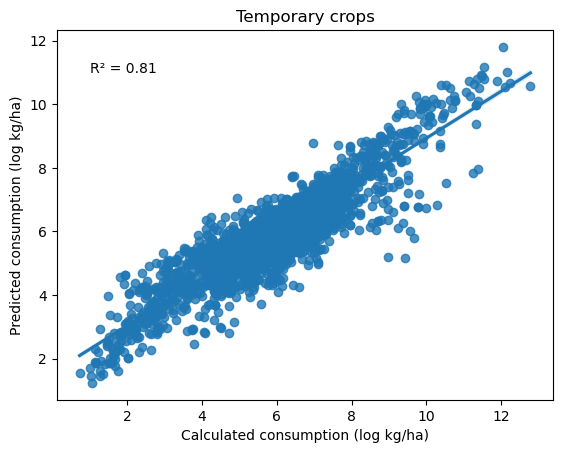

In [27]:
# plot predicted vs calculated values
biplot = sns.regplot(x=y_test, y=prediction)
biplot.set_title('Temporary crops')
biplot.set_xlabel('Calculated consumption (log kg/ha)')
biplot.set_ylabel('Predicted consumption (log kg/ha)')
#plt.annotate(f'R\u00b2 = {round(r2_score(y_test,prediction), 2)}', xy=(1, 10), xytext=(1, 10.5))
plt.annotate('R\u00b2 = {:.2f}'.format(round(r2_score(y_test,prediction), 2)), xy=(1, 10), xytext=(1, 11))

#'{:.2f}'.format(round(r2_score(y_test,prediction), 2))

plt.show()
biplot.figure.savefig('../output/figures/biplot_validation_temp.png', dpi=300, bbox_inches='tight')

In [28]:
# save X_test and prediction to evaluate the simulation
df_X_test = pd.DataFrame(X_test) 
df_X_test.to_csv('../process_data/X_test_temp.csv')
df_X_train = pd.DataFrame(X_train) 
df_X_train.to_csv('../process_data/X_train_temp.csv')
df_y_test = pd.DataFrame(y_test)
df_y_test.to_csv('../process_data/y_test_temp.csv')
df_y_predict = pd.DataFrame(prediction)
df_y_predict.to_csv('../process_data/prediction_temp.csv')

### 6. Feature importance of the final model

In [29]:
import time

start_time = time.time()
importances = model_rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in model_rf.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 0.069 seconds


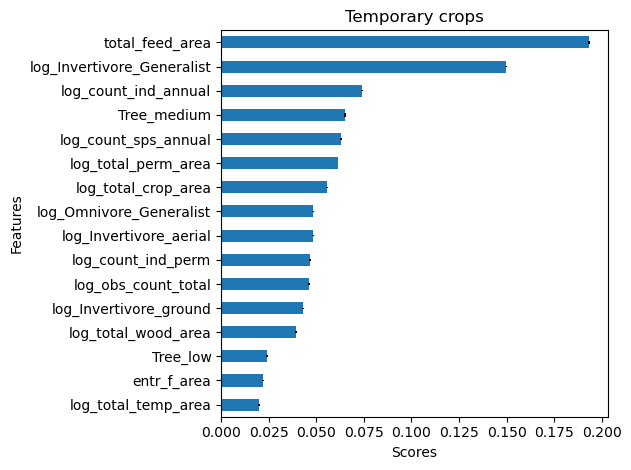

In [30]:
features_importances = pd.Series(importances, index=feature_names)
v = features_importances.sort_values(ascending=True)

fig, ax = plt.subplots()
v.plot.barh(yerr=std, ax=ax)
ax.set_title("Temporary crops")
ax.set_xlabel("Scores")
ax.set_ylabel("Features")
fig.tight_layout()
plt.savefig('../output/figures/feature_importance_temp_sel.png', dpi=300, bbox_inches='tight')
plt.show()

In [31]:
# save model for later use
import joblib

filename = '../models/temp_crops.joblib'
joblib.dump(model_rf, filename)

['../models/temp_crops.joblib']

In [32]:
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

In [33]:
X_train

array([[0.69314718, 1.60943791, 0.69314718, ..., 0.0861777 , 0.43178242,
        0.0861777 ],
       [1.60943791, 1.60943791, 1.09861229, ..., 4.81907116, 0.3074847 ,
        0.16551444],
       [4.02535169, 4.04305127, 1.79175947, ..., 2.17815501, 3.26575941,
        3.54817957],
       ...,
       [1.79175947, 2.30258509, 1.38629436, ..., 0.2390169 , 4.97175586,
        4.55440307],
       [3.29583687, 3.33220451, 1.94591015, ..., 0.        , 4.38564508,
        1.0612565 ],
       [1.09861229, 1.09861229, 1.09861229, ..., 0.77472717, 0.2390169 ,
        0.16551444]])

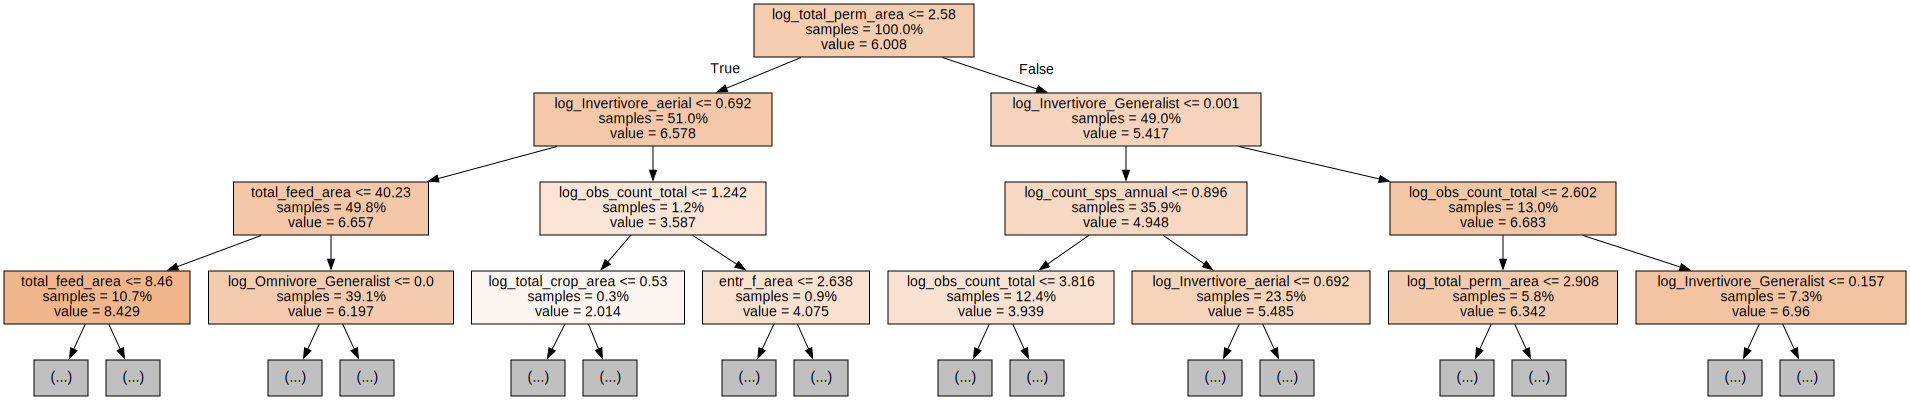

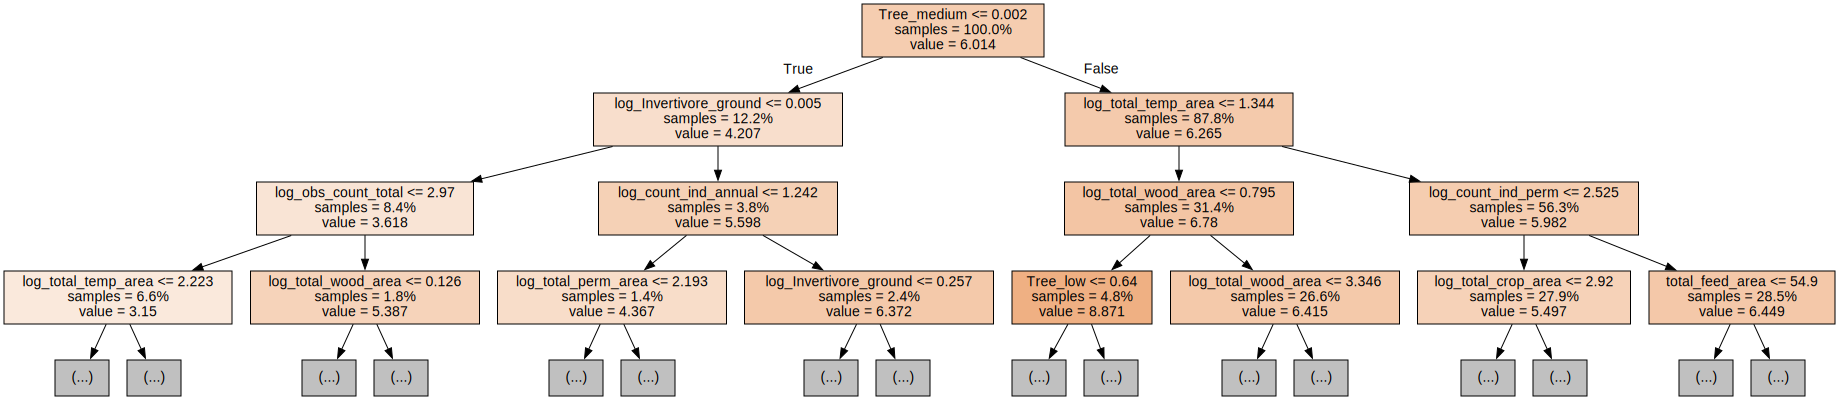

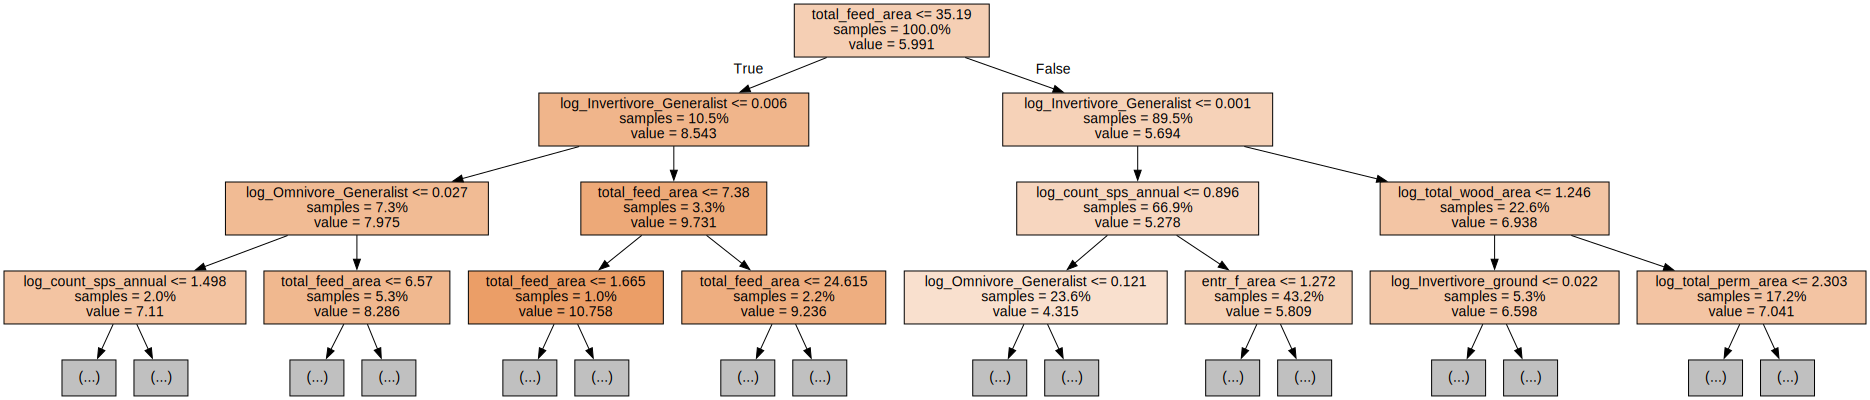

In [34]:
# Export the first three decision trees from the forest

for i in range(3):
    tree = model_rf.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=feature_names,  
                               filled=True,  
                               max_depth=3, 
                               impurity=False, 
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)

### 7. Partial Dependence Plots

Partial dependence plots help to get an insight on what is the interaction between a feature and the predicted variable.

In [35]:
feature_names

Index(['log_count_ind_annual', 'log_count_ind_perm', 'log_count_sps_annual',
       'log_obs_count_total', 'Tree_low', 'Tree_medium',
       'log_Invertivore_Generalist', 'log_Invertivore_ground',
       'log_Omnivore_Generalist', 'log_Invertivore_aerial', 'entr_f_area',
       'log_total_crop_area', 'total_feed_area', 'log_total_wood_area',
       'log_total_temp_area', 'log_total_perm_area'],
      dtype='object')

/usr/lib64/python3.11/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead
  warnings.warn(msg, category=FutureWarning)


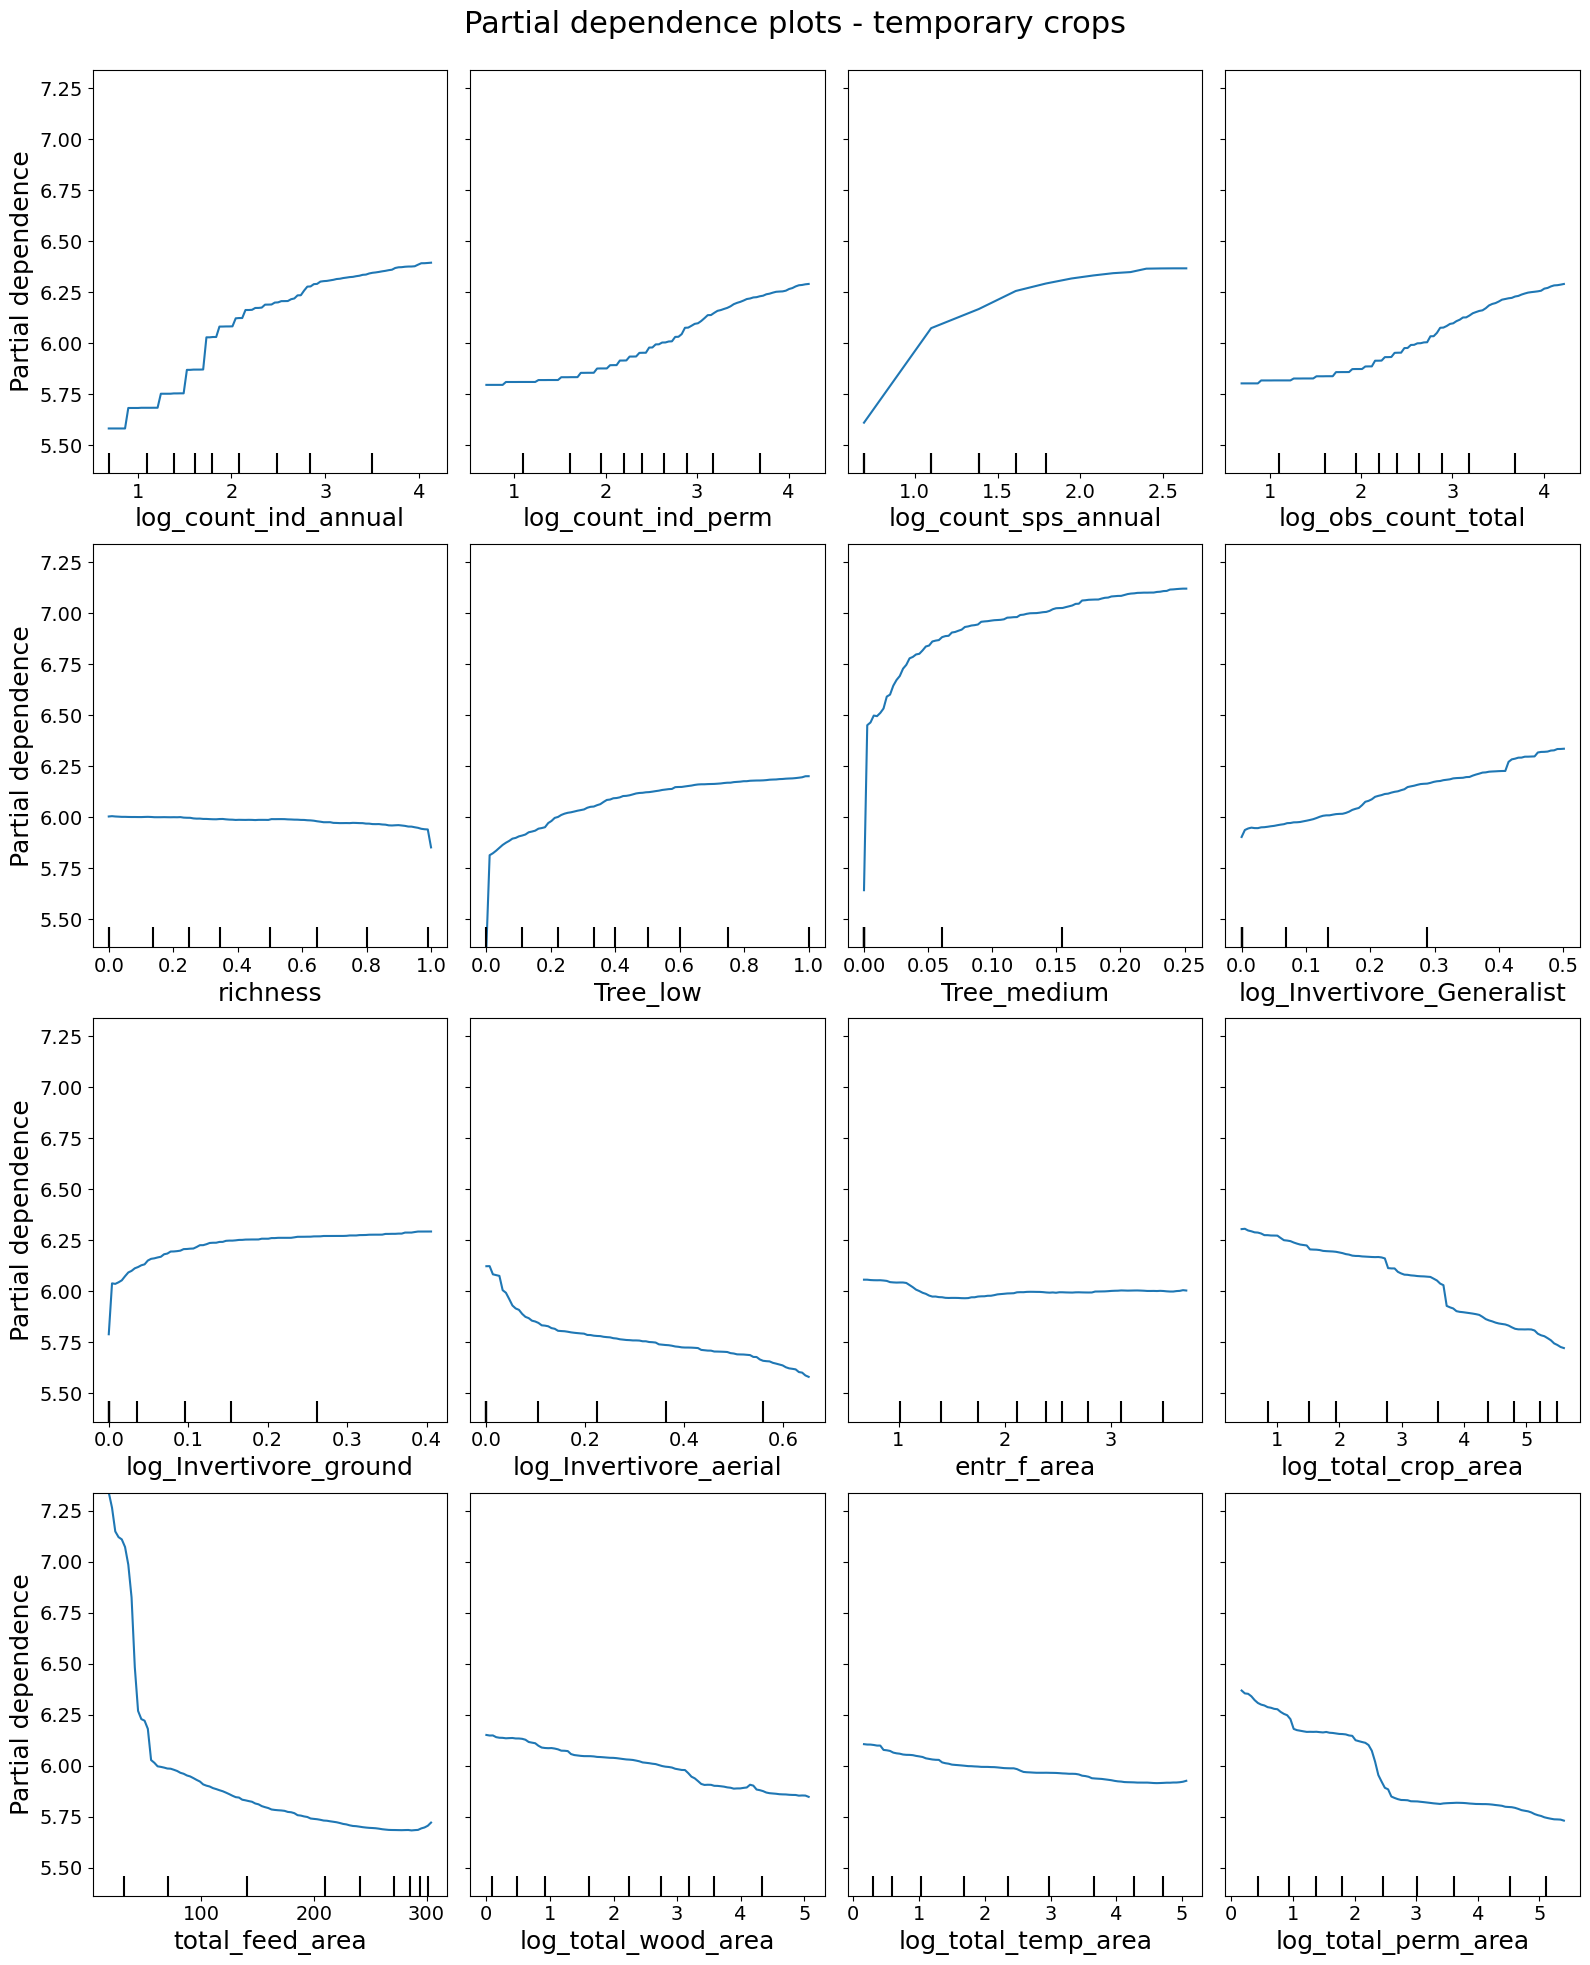

In [36]:
# Partial Dependency plots
from sklearn.inspection import plot_partial_dependence

feature_names = ['log_count_ind_annual', 'log_count_ind_perm', 'log_count_sps_annual',
       'log_obs_count_total', 'richness', 'Tree_low', 'Tree_medium',
       'log_Invertivore_Generalist', 'log_Invertivore_ground',
       'log_Invertivore_aerial', 'entr_f_area', 'log_total_crop_area',
       'total_feed_area', 'log_total_wood_area', 'log_total_temp_area',
       'log_total_perm_area']

# Select the features for which you want to create PDPs (replace with your feature indices)
features_to_plot = list(range(0, 16))


# set font size
plt.rc('axes', labelsize=18)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)

# Create partial dependence plots

fig, ax = plt.subplots(4, 4, figsize=(16, 20))
plot_partial_dependence(model_rf, X_train, features=features_to_plot, feature_names=feature_names, ax=ax)
plt.tight_layout()
fig.subplots_adjust(top=0.95)
fig.suptitle("Partial dependence plots - temporary crops", fontsize=22)
plt.rc('axes', labelsize=18)
plt.savefig('../output/figures/partial_dep_temp.png', dpi=300, bbox_inches='tight')
plt.show()